In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
cp kaggle.json ~/.kaggle/


In [4]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle (1).json


In [5]:
cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

ct-kidney-dataset-normal-cyst-tumor-and-stone.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Archive:  /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip
replace CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
!pip install split-folders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
import splitfolders

In [4]:

from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from glob import glob

#Splitting the Dataset

In [12]:
splitfolders.ratio("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.80,0.20)
)

Copying files: 12446 files [00:32, 377.35 files/s]


In [11]:
train_path = "/content/dataset/train"
test_path = "/content/dataset/val"

#Augumentation

In [9]:
train_generator = ImageDataGenerator(
    rescale=1./255,   #Normalizing Data
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest' # Filling the Gaps
)
test_generator = ImageDataGenerator(rescale=1./255.)

In [12]:
#Creating Bacthes for the Images
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=100,
    target_size=(128, 128),
    class_mode = 'categorical'
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=100,
    target_size=(128, 128), #Align with the shape of Input Data
    class_mode = 'categorical'
)

Found 9955 images belonging to 4 classes.
Found 2491 images belonging to 4 classes.


#Training Dataset

In [16]:
#Number of classes Present
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  4


In [17]:
x_data = []  # Storing the Images
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data}) # Creating DataFrame

100%|██████████| 2967/2967 [00:25<00:00, 114.51it/s]


In [18]:
from collections import Counter
Counter(y_data)  #Count the Occurences

Counter({'Normal': 4061, 'Tumor': 1826, 'Stone': 1101, 'Cyst': 2967})

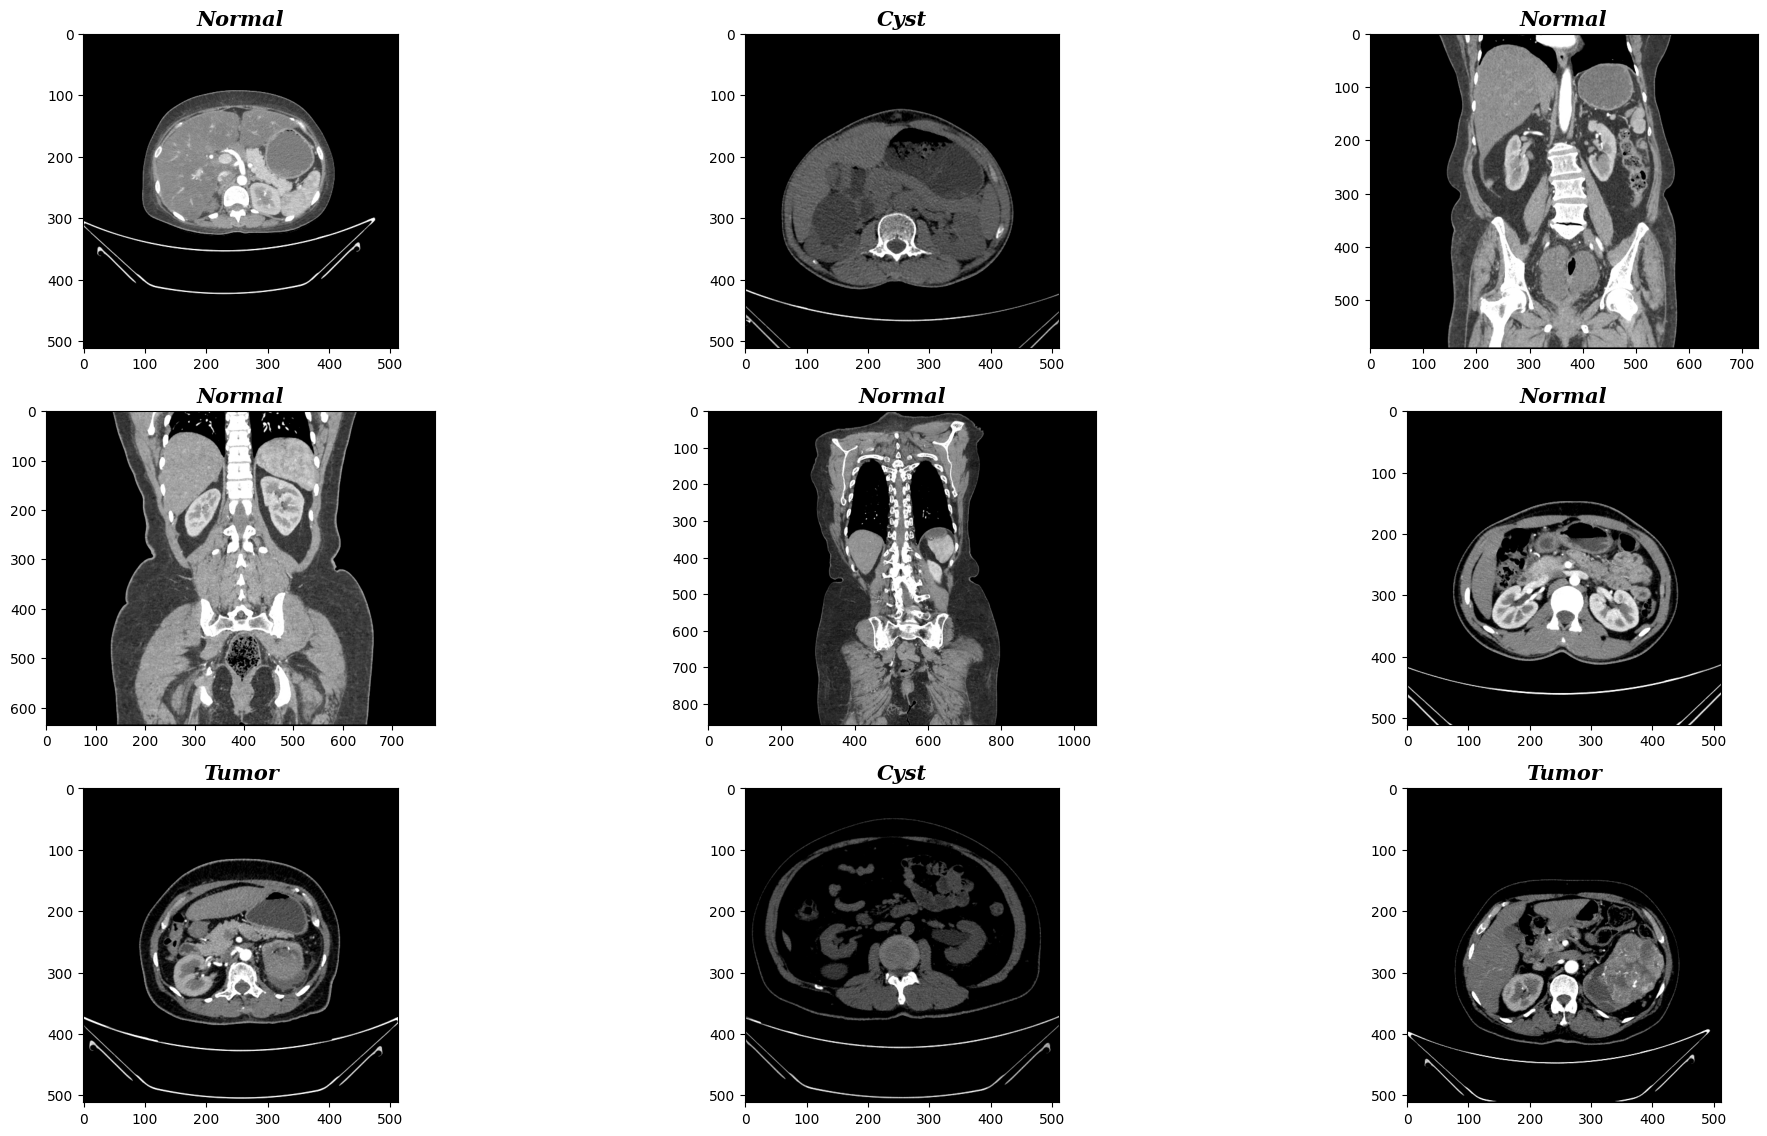

In [19]:

plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(9000)
    plt.title('{0}'.format(data.label[index]),fontdict={'fontsize': 15, 'fontweight': 'bold', 'fontstyle': 'italic', 'family': 'serif'})
    plt.imshow(data.image[index])
    plt.tight_layout()

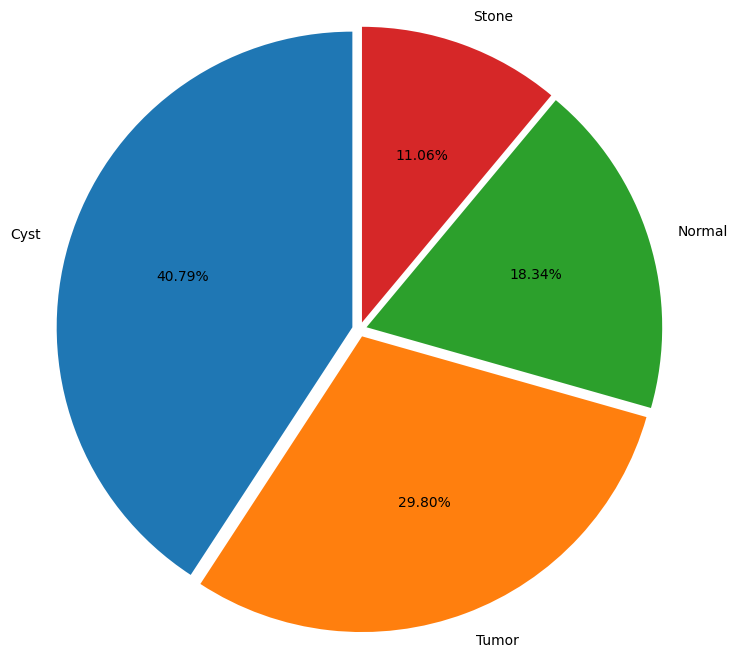

In [20]:
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05],autopct='%0.2f%%',labels=['Cyst', 'Tumor', 'Normal', 'Stone'], radius=2)
plt.show()

#Model

In [5]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 512 hidden units
model.add(Dense(512, activation='relu'))
# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
hist = model.fit_generator(
        generator = train_datagen,
        epochs=10
        ,
        validation_data = test_datagen)

Epoch 1/10
100/100 [==============================] - 446s 4s/step - loss: 1.0833 - accuracy: 0.5753 - val_loss: 0.9373 - val_accuracy: 0.6443
Epoch 2/10
100/100 [==============================] - 454s 5s/step - loss: 0.8888 - accuracy: 0.6659 - val_loss: 0.8969 - val_accuracy: 0.6937
Epoch 3/10
100/100 [==============================] - 455s 5s/step - loss: 0.7723 - accuracy: 0.7064 - val_loss: 0.7517 - val_accuracy: 0.6857
Epoch 4/10
100/100 [==============================] - 448s 4s/step - loss: 0.6838 - accuracy: 0.7351 - val_loss: 0.8834 - val_accuracy: 0.6813
Epoch 5/10
100/100 [==============================] - 443s 4s/step - loss: 0.5741 - accuracy: 0.7703 - val_loss: 1.1550 - val_accuracy: 0.6431
Epoch 6/10
100/100 [==============================] - 446s 4s/step - loss: 0.5066 - accuracy: 0.8022 - val_loss: 0.7554 - val_accuracy: 0.7567
Epoch 7/10
100/100 [==============================] - 443s 4s/step - loss: 0.4241 - accuracy: 0.8355 - val_loss: 0.8069 - val_accuracy: 0.7447

In [ ]:
#Performance

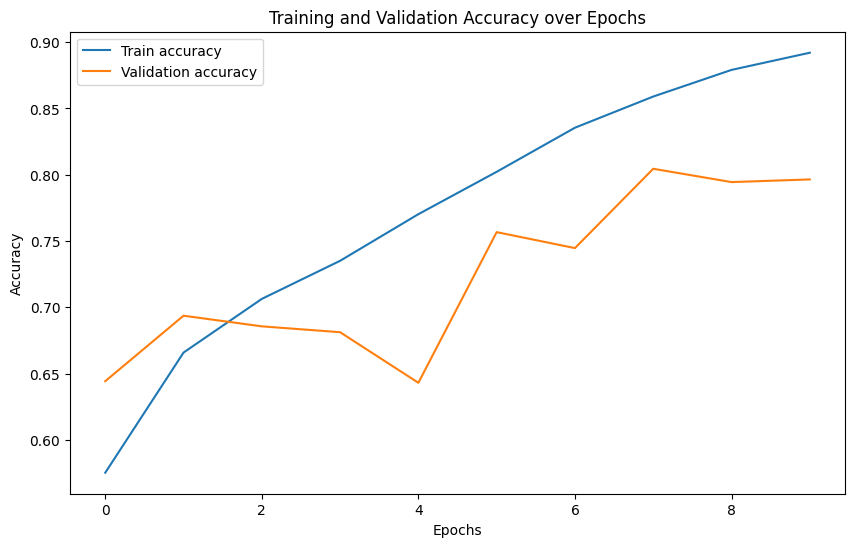

In [14]:

plt.figure(figsize=[10, 6])
plt.plot(hist.history["accuracy"], label="Train accuracy")
plt.plot(hist.history["val_accuracy"], label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()


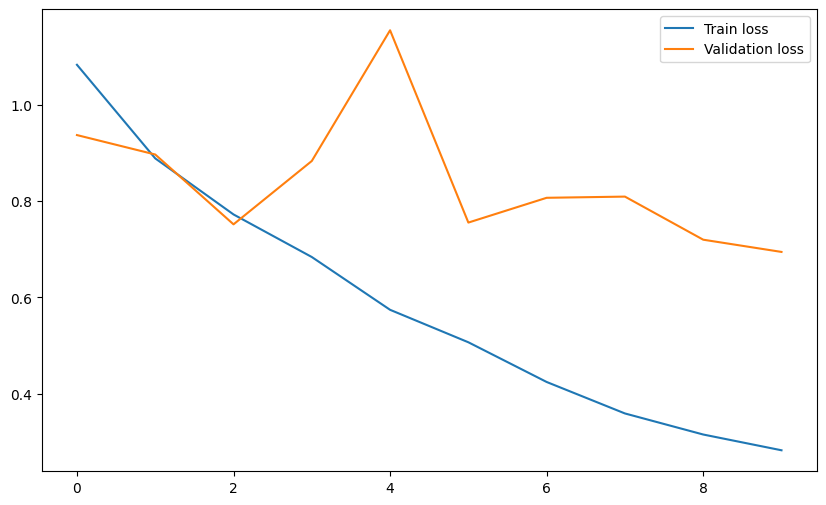

In [15]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [16]:
model.evaluate(test_datagen)

25/25 [==============================] - 34s 1s/step - loss: 0.6944 - accuracy: 0.7965


[0.6943947672843933, 0.7964673042297363]